<a href="https://colab.research.google.com/github/ramana16/EVA4/blob/master/EVA4S9%5CS9-Quiz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/')

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from config import ModelConfig
from models.resnet import ResNet18
from train import train
from results import plot_misclassified_images, plot_graph
from utilities import *
from data_engine import DataEngine
from gradcam.visualize import VisualizeCam
#from test import test

# View model config
args = ModelConfig()
args.print_config()

print()
# Set seed
init_seed(args)

data = DataEngine(args)

Mounted at /content/gdrive/
Model Parameters:
{ 'batch_size_cpu': 64,
  'batch_size_cuda': 64,
  'dropout': 0.15,
  'epochs': 35,
  'l1_decay': 3e-06,
  'l2_decay': 0.001,
  'lr': 0.1,
  'max_lr': 0.01,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1}

CUDA Available
Files already downloaded and verified
Files already downloaded and verified


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



plane   dog  deer  deer


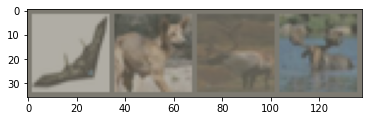

In [0]:
# get some random training images
dataiter = iter(data.train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % data.classes[labels[j]] for j in range(4)))





In [0]:
device = which_device()
net = ResNet18(args.dropout)
model = net.to(device)
show_model_summary(model, (3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=35, gamma=0.1)

def test(model, device, test_loader, criterion, classes, test_losses, test_accs,
         misclassified_imgs, correct_imgs, is_last_epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss +=criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            is_correct = pred.eq(target.view_as(pred))
            if is_last_epoch:
              misclassified_inds = (is_correct==0).nonzero()[:,0]
              for mis_ind in misclassified_inds:
                if len(misclassified_imgs) == 25:
                  break
                misclassified_imgs.append({
                    "target": target[mis_ind].cpu().numpy(),
                    "pred": pred[mis_ind][0].cpu().numpy(),
                    "img": data[mis_ind]
                })
              
              correct_inds = (is_correct==1).nonzero()[:,0]
              for ind in correct_inds:
                if len(correct_imgs) == 25:
                  break
                correct_imgs.append({
                    "target": target[ind].cpu().numpy(),
                    "pred": pred[ind][0].cpu().numpy(),
                    "img": data[ind]
                })
            correct += is_correct.sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    test_acc = 100. * correct / len(test_loader.dataset)
    test_accs.append(test_acc)

    if test_acc > 85.0:
        classwise_acc(model, device, test_loader, classes)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_acc))

def classwise_acc(model, device, test_loader, classes):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    # print class-wise test accuracies
    print()
    for i in range(10):
      print('Accuracy of %5s : %2d %%' % (
          classes[i], 100 * class_correct[i] / class_total[i]))
    print()

def run(l1_decay=0.0, l2_decay=0.0):
  test_losses = []
  test_accs = []
  misclassified_imgs = []
  correct_imgs = []
  for epoch in range(args.epochs):
      print("EPOCH:", epoch+1)
      train(model, device, data.train_loader, criterion, optimizer, epoch, l1_decay, l2_decay, scheduler)
      test(model, device, data.test_loader, criterion, data.classes, test_losses, test_accs,
           misclassified_imgs, correct_imgs, epoch==args.epochs-1)
  return test_losses, test_accs, misclassified_imgs, correct_imgs



Let us show some of the training images, for fun.



In [0]:
# train and test the model
test_losses, test_accs, misclassified_imgs, correct_imgs = run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.499837875366211 Batch_id=781 Accuracy=30.07: 100%|██████████| 782/782 [01:13<00:00, 10.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3193/10000 (31.93%)

EPOCH: 2


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.752899169921875 Batch_id=781 Accuracy=30.81: 100%|██████████| 782/782 [01:12<00:00, 10.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3159/10000 (31.59%)

EPOCH: 3


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.6943864822387695 Batch_id=781 Accuracy=31.23: 100%|██████████| 782/782 [01:13<00:00, 10.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3149/10000 (31.49%)

EPOCH: 4


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.675449848175049 Batch_id=781 Accuracy=30.98: 100%|██████████| 782/782 [01:12<00:00, 10.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3158/10000 (31.58%)

EPOCH: 5


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.7102952003479004 Batch_id=781 Accuracy=31.10: 100%|██████████| 782/782 [01:12<00:00, 10.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3158/10000 (31.58%)

EPOCH: 6


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.58353328704834 Batch_id=781 Accuracy=30.90: 100%|██████████| 782/782 [01:12<00:00, 10.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3150/10000 (31.50%)

EPOCH: 7


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=3.192685604095459 Batch_id=781 Accuracy=31.04: 100%|██████████| 782/782 [01:12<00:00, 10.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3153/10000 (31.53%)

EPOCH: 8


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.8967418670654297 Batch_id=781 Accuracy=30.99: 100%|██████████| 782/782 [01:12<00:00, 10.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3127/10000 (31.27%)

EPOCH: 9


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.847217082977295 Batch_id=781 Accuracy=30.93: 100%|██████████| 782/782 [01:12<00:00, 10.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3149/10000 (31.49%)

EPOCH: 10


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.704239845275879 Batch_id=781 Accuracy=31.03: 100%|██████████| 782/782 [01:12<00:00, 10.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0299, Accuracy: 3096/10000 (30.96%)

EPOCH: 11


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.6573400497436523 Batch_id=781 Accuracy=31.14: 100%|██████████| 782/782 [01:12<00:00, 10.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3137/10000 (31.37%)

EPOCH: 12


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.5871639251708984 Batch_id=781 Accuracy=31.07: 100%|██████████| 782/782 [01:12<00:00, 10.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3093/10000 (30.93%)

EPOCH: 13


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.669100761413574 Batch_id=781 Accuracy=31.03: 100%|██████████| 782/782 [01:12<00:00, 10.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3134/10000 (31.34%)

EPOCH: 14


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.707782745361328 Batch_id=781 Accuracy=31.25: 100%|██████████| 782/782 [01:12<00:00, 10.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3155/10000 (31.55%)

EPOCH: 15


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.453679323196411 Batch_id=781 Accuracy=31.12: 100%|██████████| 782/782 [01:12<00:00, 10.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3204/10000 (32.04%)

EPOCH: 16


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.825387954711914 Batch_id=781 Accuracy=31.06: 100%|██████████| 782/782 [01:12<00:00, 10.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3170/10000 (31.70%)

EPOCH: 17


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.639400005340576 Batch_id=781 Accuracy=31.04: 100%|██████████| 782/782 [01:12<00:00, 10.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3172/10000 (31.72%)

EPOCH: 18


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.834254741668701 Batch_id=781 Accuracy=31.06: 100%|██████████| 782/782 [01:12<00:00, 10.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3181/10000 (31.81%)

EPOCH: 19


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.9103851318359375 Batch_id=781 Accuracy=31.15: 100%|██████████| 782/782 [01:12<00:00, 10.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3184/10000 (31.84%)

EPOCH: 20


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.83896541595459 Batch_id=781 Accuracy=30.77: 100%|██████████| 782/782 [01:12<00:00, 10.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0299, Accuracy: 3139/10000 (31.39%)

EPOCH: 21


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.7434234619140625 Batch_id=781 Accuracy=31.00: 100%|██████████| 782/782 [01:12<00:00, 10.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3177/10000 (31.77%)

EPOCH: 22


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.5950145721435547 Batch_id=781 Accuracy=31.25: 100%|██████████| 782/782 [01:12<00:00, 10.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3197/10000 (31.97%)

EPOCH: 23


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.5187244415283203 Batch_id=781 Accuracy=31.12: 100%|██████████| 782/782 [01:12<00:00, 10.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3130/10000 (31.30%)

EPOCH: 24


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.8862357139587402 Batch_id=781 Accuracy=31.15: 100%|██████████| 782/782 [01:12<00:00, 10.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3171/10000 (31.71%)

EPOCH: 25


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.759434223175049 Batch_id=781 Accuracy=30.92: 100%|██████████| 782/782 [01:12<00:00, 10.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3168/10000 (31.68%)

EPOCH: 26


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.845557689666748 Batch_id=781 Accuracy=31.15: 100%|██████████| 782/782 [01:12<00:00, 10.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3157/10000 (31.57%)

EPOCH: 27


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.9562740325927734 Batch_id=781 Accuracy=30.84: 100%|██████████| 782/782 [01:12<00:00, 10.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3139/10000 (31.39%)

EPOCH: 28


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.5966577529907227 Batch_id=781 Accuracy=30.88: 100%|██████████| 782/782 [01:12<00:00, 10.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0299, Accuracy: 3141/10000 (31.41%)

EPOCH: 29


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.8039183616638184 Batch_id=781 Accuracy=31.08: 100%|██████████| 782/782 [01:12<00:00, 10.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0299, Accuracy: 3137/10000 (31.37%)

EPOCH: 30


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.800351619720459 Batch_id=781 Accuracy=31.16: 100%|██████████| 782/782 [01:12<00:00, 10.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3193/10000 (31.93%)

EPOCH: 31


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.8985180854797363 Batch_id=781 Accuracy=30.95: 100%|██████████| 782/782 [01:12<00:00, 10.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0299, Accuracy: 3115/10000 (31.15%)

EPOCH: 32


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.5924978256225586 Batch_id=781 Accuracy=30.80: 100%|██████████| 782/782 [01:12<00:00, 10.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3142/10000 (31.42%)

EPOCH: 33


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.7689552307128906 Batch_id=781 Accuracy=31.00: 100%|██████████| 782/782 [01:12<00:00, 10.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3180/10000 (31.80%)

EPOCH: 34


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.9232473373413086 Batch_id=781 Accuracy=31.05: 100%|██████████| 782/782 [01:12<00:00, 10.80it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Test set: Average loss: 0.0298, Accuracy: 3092/10000 (30.92%)

EPOCH: 35


L2_loss=458.6564025878906 L1_loss=109376.5859375 Loss=2.5647072792053223 Batch_id=781 Accuracy=31.22: 100%|██████████| 782/782 [01:12<00:00, 10.79it/s]


Test set: Average loss: 0.0298, Accuracy: 3169/10000 (31.69%)



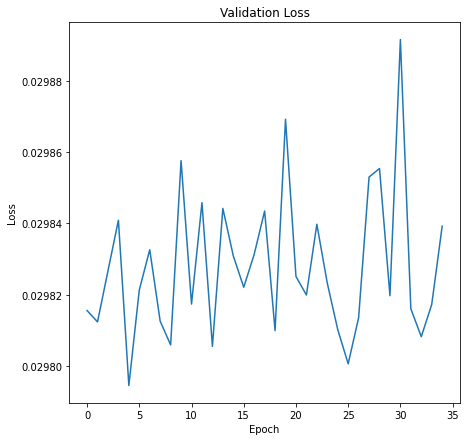

In [0]:
plot_graph(test_losses, "Loss")



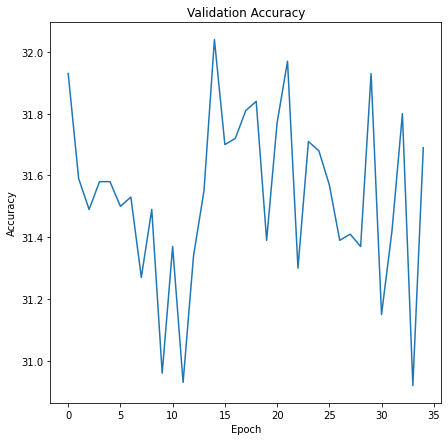

In [0]:
plot_graph(test_accs, "Accuracy")



In [0]:
plot_misclassified_images(misclassified_imgs, data.classes, "misclassified_imgs.png")

In [0]:
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = VisualizeCam(model,data.classes, target_layers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

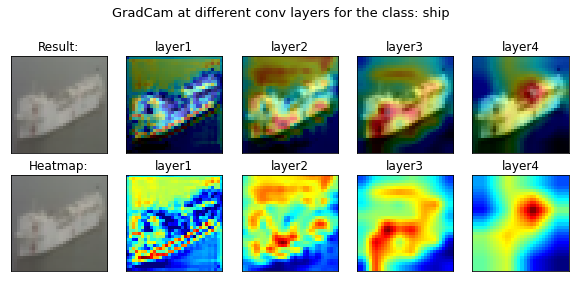

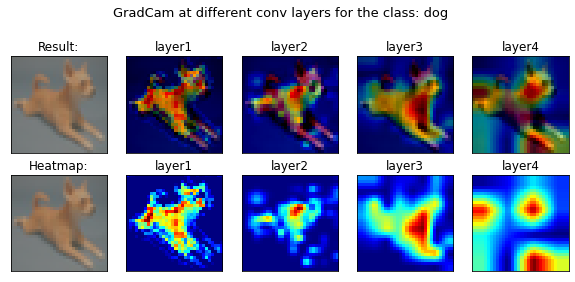

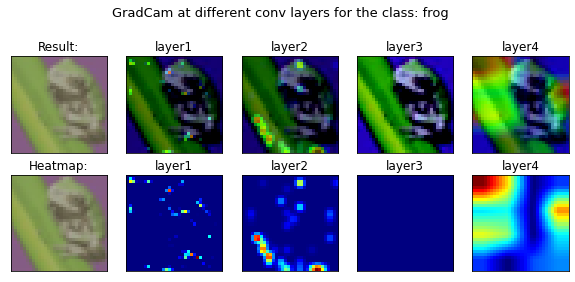

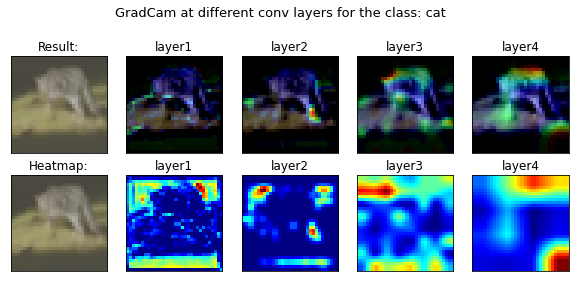

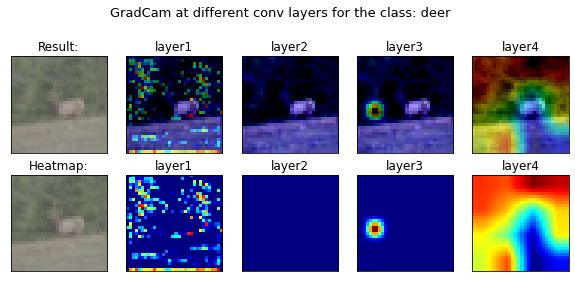

In [0]:
num_img = 5
correct_pred_imgs = []
for i in range(num_img):
  correct_pred_imgs.append(torch.as_tensor(correct_imgs[i]["img"]))
viz_cam(torch.stack(correct_pred_imgs), target_layers, metric="correct")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

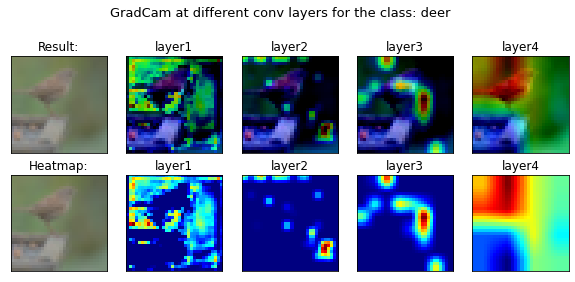

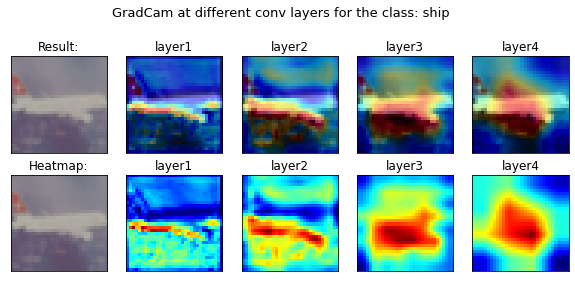

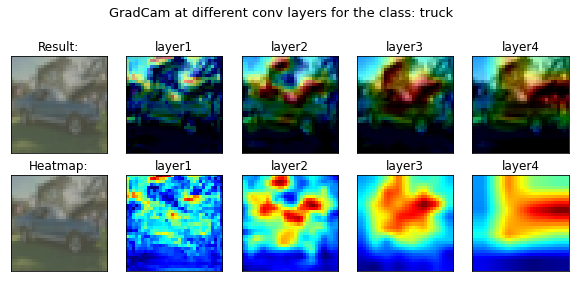

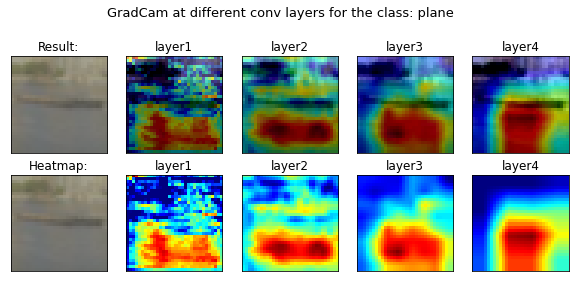

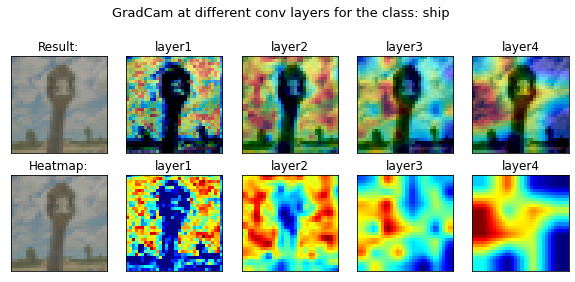

In [0]:
incorrect_pred_imgs = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
viz_cam(torch.stack(incorrect_pred_imgs), target_layers, metric="incorrect")